In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [1]:
import torch #for using tensors
import torch.nn as nn # creating neural network
import torch.nn.functional as F # recallable functions like relu,sigmoid and etc.
import torchvision # subpackage for vision models
import torchvision.transforms as transforms # image augmentation
import torch.optim as optim # optimisation functions like sgd, adam
from torch.utils.data import DataLoader # creating a data loader
from torchvision.transforms import ToTensor # converting image to tensor
import matplotlib.pyplot as plt 
from torchvision import datasets

In [24]:
train_on_gpu=torch.cuda.is_available()

In [4]:
batch_size=64

In [6]:
data_dir = '/Users/mehrac/Desktop/DSA-Python/seg_data'
    
transform = transforms.Compose([transforms.RandomResizedCrop(150),transforms.ToTensor()])
    
train_set = datasets.ImageFolder(data_dir + '/seg_train',transform=transform)
test_set = datasets.ImageFolder(data_dir + '/seg_test',transform=transform)

    
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [7]:
len(train_loader)

220

In [9]:
data_dir

'/content/drive/MyDrive/Colab Notebooks/Week 11/Python-2/day1/Data'

In [8]:
for images, Labels in train_loader:
  print(images.shape)
  break

torch.Size([64, 3, 150, 150])


In [10]:
for X,y in train_loader:
    print(X.shape)
    print(y)
    break

torch.Size([64, 3, 150, 150])
tensor([4, 5, 1, 2, 1, 2, 0, 5, 5, 3, 5, 2, 4, 4, 4, 5, 3, 1, 1, 3, 1, 4, 0, 0,
        4, 0, 1, 4, 2, 3, 5, 5, 0, 3, 5, 5, 1, 4, 2, 4, 3, 0, 3, 3, 3, 3, 3, 5,
        5, 1, 4, 5, 2, 3, 4, 1, 2, 2, 3, 5, 4, 3, 2, 4])


**Modelling**

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=5,padding=2)
        self.conv2 = nn.Conv2d(64,128,kernel_size=5,stride=2,padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*37*37,512)
        self.fc2 = nn.Linear(512,512)
        self.out = nn.Linear(512,10)
        self.drop_out = nn.Dropout()
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.pool(X)
        X = X.reshape(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        out = self.out(X)
        return X

In [13]:
model = NeuralNetwork()
# defining model

In [14]:
num_epochs = 6
num_classes = 10
learning_rate = 0.001

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [21]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street', ]

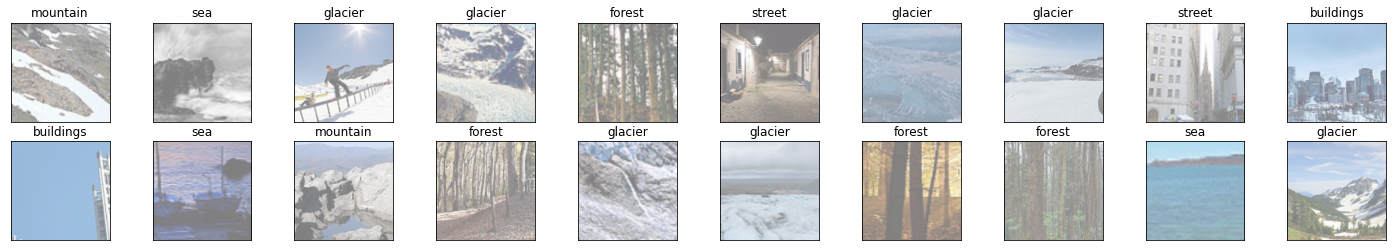

In [22]:
import matplotlib.pyplot as plt 
%matplotlib inline

# helper function to un-normalize and display an image 
def imshow(img):
  img = img/2+0.5 # unnormalize
  plt.imshow(np.transpose(img, (1, 2, 0))) # convert from Tensor image 
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels 
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[]) 
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

In [16]:
# Train the model
model.train()
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/6], Step [100/220], Loss: 6.2383, Accuracy: 14.06%
Epoch [1/6], Step [200/220], Loss: 6.2383, Accuracy: 17.19%
Epoch [2/6], Step [100/220], Loss: 6.2383, Accuracy: 20.31%
Epoch [2/6], Step [200/220], Loss: 6.2383, Accuracy: 12.50%
Epoch [3/6], Step [100/220], Loss: 6.2383, Accuracy: 20.31%
Epoch [3/6], Step [200/220], Loss: 6.2383, Accuracy: 18.75%
Epoch [4/6], Step [100/220], Loss: 6.2383, Accuracy: 15.62%
Epoch [4/6], Step [200/220], Loss: 6.2383, Accuracy: 6.25%
Epoch [5/6], Step [100/220], Loss: 6.2383, Accuracy: 12.50%
Epoch [5/6], Step [200/220], Loss: 6.2383, Accuracy: 14.06%
Epoch [6/6], Step [100/220], Loss: 6.2383, Accuracy: 17.19%
Epoch [6/6], Step [200/220], Loss: 6.2383, Accuracy: 15.62%


In [18]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 14.532756900565346 %


The model needs further tuning to show a better result. 
